In [99]:
from IPython.display import clear_output 
import matplotlib.pyplot as plt
import numpy as np
from firedrake import *
from firecracker import *

(1127, 2)


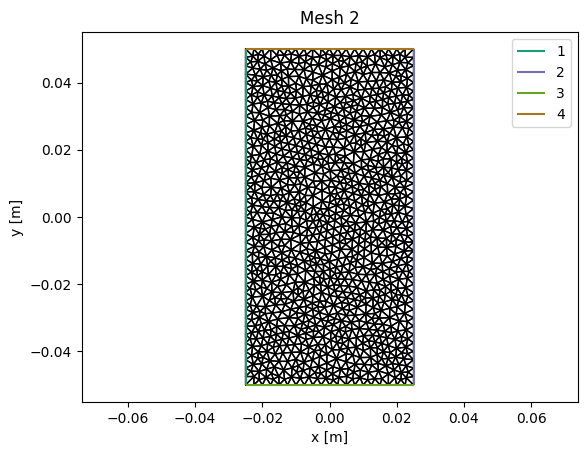

In [100]:
width, height = .05, .1
mesh_size = 0.0025

# load the mesh generated with Gmsh
mesh = mesh2d_rectangle(width, height, mesh_size,
                 filename = None, delete_mesh_file = True)
coords = mesh.coordinates.dat.data
print(coords.shape)
# Plot the mesh
fig1, ax1 = plt.subplots()
triplot(mesh, axes=ax1)
ax1.set_title("Mesh 2")

plt.legend()
plt.axis('equal')
ax1.set_ylim(-height*1.1/2, height*1.1/2)
ax1.set_xlim(-width*1.1/2, width*1.1/2)
ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
# Show the plot
plt.show()

n = FacetNormal(mesh)
# n('-')`: This notation is used in the context of discontinuous Galerkin methods or when dealing with interior facets
# The `perp` function computes the perpendicular (or tangent) to the given vector
n_, t_= n('-'), perp(n('-')) 

In [101]:
# define FE spaces and functions
V = VectorFunctionSpace(mesh, "DG", 1) # space for discontinuous displacement vector (u)
W = VectorFunctionSpace(mesh, "DG", 1, dim=3) # space for discontinuous stress tensor (sig)
S = FunctionSpace(mesh, "HDiv Trace", 0) # space for facet-based internal variables (dmax_n, dmax_t, gmax, flag)
u = Function(V, name="Displacement [mm]")
v, u_ = TestFunction(V), TrialFunction(V)
sig = Function(W, name="Stress [MPa]")
dmax_n = Function(S, name="Maximum normal opening [mm]")
dmax_t = Function(S, name="Maximum tangential opening [mm]")
gmax = Function(S, name="Maximum effective opening [-]")
flag = Function(S, name="Joint state flag") # (1: active; 0: failed)

In [102]:
# create rigid body modes
x, y = SpatialCoordinate(mesh)
b0 = Function(V) 
b1 = Function(V) 
b2 = Function(V)
b0.interpolate(Constant([1, 0]))
b1.interpolate(Constant([0, 1])) 
b2.interpolate(as_vector([-y, x]))
nullmodes = VectorSpaceBasis([b0, b1, b2]) 
nullmodes.orthonormalize()
dS = dS(degree=2) # interior facet integration measure 

In [103]:
def facet_project(v, V):
# """
# Project an expression 'v' into a facet-based function space 'V'.
# If 'v' is a dictionary then we can project different expressions on regions with different cell tags.
# The default solver parameters apply conjugate gradients as an iterative linear solver, with successive over-relaxation as a preconditioner.
# """
    v_, dv = TestFunction(V), TrialFunction(V) 
    a = inner(avg(v_), avg(dv))*dS
    if isinstance(v, dict):
        L = sum([inner(avg(v_), val)*dS(reg) for (reg, val) in v.items()])
    else:
        L = inner(avg(v_), v)*dS
    u = Function(V)
    solve(a==L, u, solver_parameters={'ksp_type': 'cg', 'pc_type': 'jacobi'})
    return u

In [104]:
# elastic parameters
E = Constant(25e9) # Young’s modulus [MPa]
nu = Constant (0.3) # Poisson ratio # Lame parameters
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)
# constitutive parameters
sig0 = Constant(2e6) # uniaxial tensile strength [MPa]
c = Constant(3e6) # internal cohesion [MPa]
phi = Constant(np.deg2rad(35)) # internal friction angle [degree]
pen = Constant(10*E) # penalty stiffness

In [105]:
# strain tensor
def epsilon(u_):
    return sym(grad(u_)) # = 0.5*(grad(u_) + grad(u_).T)
# elastic stress -strain relation
# def sigma(u_):
#     I = Identity(u_.geometric_dimension()) # identity tensor 
#     return lmbda*tr(epsilon(u_))*I + 2*mu*epsilon(u_)
def sigma(u_):
    dim = mesh.geometric_dimension()  # Get geometric dimension from the mesh
    I = Identity(dim)  # identity tensor 
    return lmbda*tr(epsilon(u_))*I + 2*mu*epsilon(u_)

# normal opening displacement
def d_n(u_):
    return dot(jump(u_), n_)
# tangential opening displacement
def d_t(u_):
    return dot(jump(u_), t_)

In [106]:
# define traction -separation laws
pos = lambda X: (X+abs(X))/2 # take the positive part of X 
Gf1 = Constant(100) # Mode I initial fracture energy [N/mm]
GF1 = 10*Gf1 # Mode I total fracture energy
Gf2, GF2 = 10*Gf1, 10*GF1 # Mode II initial/total fracture energy
# parameters for mode I traction-separation law in the normal direction 
f0_n = sig0 # peak traction
d0_n = f0_n/pen # normal opening displacement corresponding to the peak traction
dk_n = 2 * Gf1 / f0_n # normal opening displacement corresponding to the kink point [mm]
k = 1-dk_n*f0_n/2/Gf1
fk_n = k*f0_n # normal traction corresponding to the kink point 
df_n = 2*(GF1-(1-k)*Gf1)/fk_n # normal opening displacement corresponding to null traction
s1_n = (fk_n-f0_n)/(dk_n-d0_n) # slope of the first softening branch 
s2_n = -fk_n/(df_n-dk_n) # slope of the second softening branch
# parameters for mode II traction-separation law in the tangential direction
f0_t = c # peak traction (without frictional contribution)
d0_t = f0_t/pen # tangential opening displacement corresponding to the peak traction
fk_t = k*f0_t # tangential traction corresponding to the kink point 
dk_t = 2*Gf2*(1-k)/f0_t #tangential opening displacement corresponding to the kink point
df_t = 2*(GF2-(1-k)*Gf2)/fk_t # tangential opening displacement corresponding to null traction
s1_t = (fk_t-f0_t)/(dk_t-d0_t) # slope of the first softening branch 
s2_t = -fk_t/(df_t-dk_t) # slope of the second softening branch

In [125]:
d0_n

Division(Constant([2000000.], 21932), Constant([2.5e+11], 21935))

In [107]:
# effective opening
def g(u_):
    return sqrt((pos(d_n(u_))/df_n)**2 + (d_t(u_)/df_t)**2)
# virgin -loading definition of the traction -separation laws
def Tn_virgin(d_n):
    return conditional(d_n<=d0_n, pen*d_n, conditional(d_n<=dk_n, f0_n + s1_n*(d_n-d0_n), fk_n + s2_n*(d_n-dk_n)))
def Tt_virgin(d_t):
    return conditional(abs(d_t)<=d0_t, pen*d_t, sign(d_t)*(conditional(abs(d_t)<=dk_t, f0_t + s1_t*(abs(d_t)-d0_t), fk_t + s2_t*(abs(d_t)-dk_t))+ pen* pos(-d_n(u)) * tan(phi)))
# unloading/reloding definition of the traction-separation laws
def Tn_ur(d_n, dmax):
    return conditional(dmax<=d0_n, pen*d_n, Tn_virgin(dmax)/dmax * d_n)
def Tt_ur(d_t, dmax):
    return conditional(dmax<=d0_t, pen*d_t, Tt_virgin(dmax)/dmax * d_t) # complete definition of the traction-separation laws
def Tn(d_n, dmax):
    return conditional(d_n>=dmax, Tn_virgin(d_n), Tn_ur(d_n, dmax))
def Tt(d_t, dmax):
    return conditional(abs(d_t)>=dmax, Tt_virgin(d_t), Tt_ur(d_t, dmax)) 

flag.assign(facet_project(1, S)) # initial activeness of all the jointelements along the interior facets
T = (Tn(d_n(u), avg(dmax_n))*n_ + Tt(d_t(u), avg(dmax_t))*t_)*avg(flag)
# total traction vector

In [108]:
top_plate_u = Constant(as_vector([0, 0]))
bottom_plate_u = Constant(as_vector([0, 0]))
confinement = Constant(1e6)

top_BC = pen * dot(v, (u - top_plate_u))*ds(4)
bottom_BC = pen * dot(v, (u - bottom_plate_u))*ds(3)
radial_BC = confinement * dot(n,v)*ds((1,2))

F_ext = top_BC + bottom_BC + radial_BC # external virtual work

F = inner(sigma(u), epsilon(v))*dx + inner(T, jump(v))*dS + F_ext #residual form of the variational problem
# define the nonlinear problem and set the solver
problem = NonlinearVariationalProblem(F, u)
solver_parameters = {"ksp_type": "fgmres", "pc_type": "ilu", 'snes_atol': 1e-5}
solver = NonlinearVariationalSolver(problem , solver_parameters= solver_parameters , nullspace=nullmodes)


In [109]:
# represent a 2D tensor as a 3-dimensional vector
def vector_2D(X):
    return as_vector([X[0,0], X[1,1], X[0,1]])
#create output file
outfile = File("UCS/ucs.pvd")
outfile.write(u, sig, time=0) 
freq = 10
# load-stepping loop
steps = np.concatenate((np.linspace(0, 1.1, 2000), np.linspace(1.001, 2, 9000)))
# np.linspace(3, 3.3, 1000)))
# steps = np.concatenate((np.linspace(0, 0.9, 100), np.linspace(0.9, 1.2, 2000)))
sigy = [0] # horizontal stress at notch tip [MPa] x
CMOD = [0] # crack mouth opening displacement [mm]
RF = [0] # vertical reaction force at top loading point [N/mm] P
disp = [0] # vertical displacement at top loading point [mm] U
sigma_cout1 = [0]

In [110]:
for i in range(10000):
    print("Increment:", i+1)
    if av_vertical_stress < 5.2 * 1e6:
        top_plate_u.assign(top_plate_u - as_vector([0, 0.00001])) # increase the loading increment by increment
    elif av_vertical_stress < 5.33 * 1e6:
        top_plate_u.assign(top_plate_u - as_vector([0, 0.0000001]))
    else:
        top_plate_u.assign(top_plate_u - as_vector([0, 0.00000001]))
    solver.solve() # solve the nonlinear equation for u
    # once convergent solution is obtained for the current load increment , update stress and internal variables
    sig.assign(project(vector_2D(sigma(u)), W))
    dn_, dt_, g_ = facet_project(d_n(u), S), facet_project(d_t(u), S), facet_project(g(u), S)
   
    dmax_n_proj = project(conditional(dn_>dmax_n, dn_, dmax_n), S)
    dmax_n.assign(dmax_n_proj)

    dmax_t_proj = project(conditional(abs(dt_)>dmax_t, abs(dt_), dmax_t), S)
    dmax_t.assign(dmax_t_proj) 
    gmax_proj = project(conditional(g_>gmax, g_, gmax), S)
    gmax.assign(gmax_proj)

    flag.assign(facet_project(conditional(avg(gmax)<1, 1, 0), S))
    clear_output(wait=True)
    vertical_stress = (.5*(abs(assemble(sigma(u)[1, 1]*ds(3)))+abs(assemble(sigma(u)[1, 1]*ds(4)))))
    av_vertical_stress = -sig.dat.data[:,1].mean()
    print("Vertical stress:", av_vertical_stress / 1e6, "MPa")

    


    if i % freq == 0:
        outfile.write(u, sig)
    
    #outfile.write(u, sig, time=t)

Vertical stress: 5.336473524313795 MPa
Increment: 662


ConvergenceError: Nonlinear solve failed to converge after 50 nonlinear iterations.
Reason:
   DIVERGED_MAX_IT

In [ ]:
outfile.write(u, sig)

In [115]:
d0_n

Division(Constant([2000000.], 21932), Constant([2.5e+11], 21935))